<a href="https://colab.research.google.com/github/heyitzrizki/final-project-ds49-group3/blob/main/modeling/Model_Development_no_outlier_partial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.1 Import Libraries

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Train test dan Hyperparameter Tuning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, fbeta_score, roc_auc_score, roc_curve,
    classification_report, confusion_matrix
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import sklearn

warnings.filterwarnings("ignore")

# 0.2 Load Dataset

In [43]:
url = 'https://raw.githubusercontent.com/heyitzrizki/final-project-ds49-group3/refs/heads/main/data/df_no_outlier_partial_encoded.csv'
df = pd.read_csv(url)
df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,item_price_range,...,store_primary_category_vegetarian,store_primary_category_vietnamese,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,order_protocol_Unknown
0,4,3441,4,557.0,1239.0,33,14,21,62,682,...,False,False,True,False,False,False,False,False,False,False
1,1,1900,1,1400.0,1400.0,1,2,2,67,0,...,False,False,False,True,False,False,False,False,False,False
2,1,1900,1,1900.0,1900.0,1,0,0,29,0,...,False,False,True,False,False,False,False,False,False,False
3,6,6900,5,600.0,1800.0,1,1,2,51,1200,...,False,False,True,False,False,False,False,False,False,False
4,3,3900,3,1100.0,1600.0,6,6,9,39,500,...,False,False,True,False,False,False,False,False,False,False


# Log Data Skewed

## 1.1 Verify Numerical Columns Skewness

In [44]:
continuous_features = [
    'total_items', 'num_distinct_items',
                      'min_item_price', 'max_item_price',
                      'total_onshift_partners', 'total_busy_partners',
                      'total_outstanding_orders'
]

df_skew_verify = df.loc[:, continuous_features]

In [45]:
skew_ft = []

for i in continuous_features:
    # list of skew for each corresponding feature
    skew_ft.append(abs(df_skew_verify[i].skew()))

df_skewed = pd.DataFrame(
    {
        "Columns": continuous_features,
        "Abs_Skew": skew_ft
    }
)

sk_features = df_skewed[df_skewed["Abs_Skew"] > 0.5]["Columns"].tolist()
print("List of skewed features:\n")
print(sk_features)

List of skewed features:

['total_items', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']


In [46]:
# loop over i (features) to calculate Log of surfaces
for i in sk_features:

    df[i] = np.log((df[i]) + 1)

Text(0, 0.5, '')

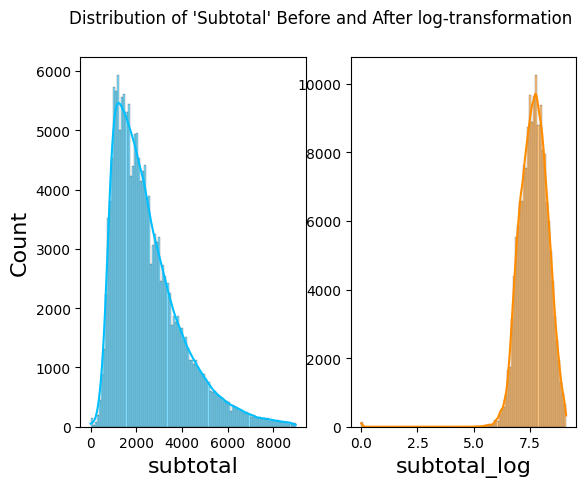

In [47]:
# Log transformation of the target variable "subtotal"
df["subtotal_log"] = np.log1p(df["subtotal"])

# Plot the distribution before and after transformation
fig, axes = plt.subplots(1, 2)
fig.suptitle("Distribution of 'Subtotal' Before and After log-transformation")
fontsize = 16

# before log transformation
p = sns.histplot(
    ax=axes[0],
    x=df["subtotal"],
    kde=True,
    bins=100,
    color="deepskyblue"
)
p.set_xlabel("subtotal", fontsize=fontsize)
p.set_ylabel("Count", fontsize=fontsize)

# after log transformation
q = sns.histplot(
    ax=axes[1],
    x=df["subtotal_log"],
    kde=True,
    bins=100,
    color="darkorange"
)

q.set_xlabel("subtotal_log", fontsize=fontsize)
q.set_ylabel("", fontsize=fontsize)

In [48]:
# Drop the original SalePrice
df.drop(
    columns=["subtotal"],
    inplace=True
)

In [49]:
df.head()

,total_items,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,item_price_range,store_primary_category_Other,...,store_primary_category_vietnamese,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,order_protocol_Unknown,subtotal_log
0,1.609438,1.609438,6.324359,7.122867,3.526361,2.708050,3.091042,62,682,False,...,False,True,False,False,False,False,False,False,False,8.143808
1,0.693147,0.693147,7.244942,7.244942,0.693147,1.098612,1.098612,67,0,False,...,False,False,True,False,False,False,False,False,False,7.550135
2,0.693147,0.693147,7.550135,7.550135,0.693147,0.000000,0.000000,29,0,True,...,False,True,False,False,False,False,False,False,False,7.550135
3,1.945910,1.791759,6.398595,7.496097,0.693147,0.693147,1.098612,51,1200,True,...,False,True,False,False,False,False,False,False,False,8.839422
4,1.386294,1.386294,7.003974,7.378384,1.945910,1.945910,2.302585,39,500,True,...,False,True,False,False,False,False,False,False,False,8.268988


# Data Splitting and Standardization

#### 2.1 Splitting the Dataset into Train and Test

In [50]:
y = df["subtotal_log"] #Target
X = df.drop(columns="subtotal_log")
print(X.shape)
print(y.shape)

(167911, 90)
(167911,)


In [51]:
# Create 150 quantile bins for even distribution
bins = np.linspace(0, len(y), 150)
y_binned = np.digitize(y, bins)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y_binned,
    shuffle=True,
    random_state=42
)

print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

X_train:(134328, 90)
y_train:(134328,)

X_test:(33583, 90)
y_test:(33583,)


In [52]:
y_test.head()

,subtotal_log
121154,8.206856
77878,6.731018
115613,7.981392
1906,7.783641
86091,8.111928


#### 2.2 Data Standarization

In [53]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),
                       columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),
                      columns=X_test.columns, index=X_test.index)

In [54]:
X_train

,total_items,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,item_price_range,store_primary_category_Other,...,store_primary_category_vegetarian,store_primary_category_vietnamese,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,order_protocol_Unknown
39999,-1.356915,-0.584963,0.545332,0.085757,-1.022487,-1.081174,-1.070050,-0.761905,-0.482759,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
89624,-0.563171,-0.584963,0.460519,-0.093612,0.891598,0.828201,0.938108,-0.761905,-0.482759,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
167096,0.436829,0.000000,-0.154512,-1.051827,-0.598921,-0.563237,-0.494948,-0.333333,-0.344828,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
157832,-0.563171,0.000000,0.303246,0.187329,0.657108,0.506867,0.635281,-0.095238,-0.037241,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
72088,0.793745,1.000000,-0.862909,-1.394322,-0.469192,-0.396499,-0.070050,0.666667,-0.103448,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63949,-0.563171,0.000000,0.362798,0.078901,0.021871,0.063183,0.247038,0.428571,-0.206897,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70634,-0.563171,0.000000,0.456952,-0.101155,-1.307198,-1.180952,-0.800473,-0.190476,-0.482759,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
133891,-0.563171,0.000000,-0.769546,-0.045307,0.483839,0.472637,0.635281,0.571429,0.586207,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144200,-0.563171,0.000000,-0.192616,0.078901,-1.430246,-1.081174,-1.070050,-0.809524,0.366897,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Modelling

## 3.1 Models and Metrics Selection

In [55]:
!pip install catboost

In [56]:
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import HuberRegressor, QuantileRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [57]:
# Let's define a function for each metrics
# R²
def rsqr_score(test, pred):
    """Calculate R squared score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        R squared score
    """
    r2_ = r2_score(test, pred)
    return r2_


# RMSE
def rmse_score(test, pred):
    """Calculate Root Mean Square Error score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Root Mean Square Error score
    """
    rmse_ = np.sqrt(mean_squared_error(test, pred))
    return rmse_


# Print the scores
def print_score(test, pred):
    """Print calculated score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        print the regressor name
        print the R squared score
        print Root Mean Square Error score
    """

    print(f"- Regressor: {regr.__class__.__name__}")
    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}\n")

In [58]:
# Define regression models
dtr =  DecisionTreeRegressor()
huber = HuberRegressor(epsilon=1.35)  # robust against outliers
# quantile = QuantileRegressor(quantile=0.5, alpha=0.001, solver='highs')  # median regression
rdf = RandomForestRegressor()
xgboost = XGBRegressor()
lgbm = LGBMRegressor()
catboost = CatBoostRegressor()

# Train models on X_train and y_train
for regr in [dtr, huber, rdf, xgboost, lgbm, catboost]:
    # fit the corresponding model
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    # Print the defined metrics above for each classifier
    print_score(y_test, y_pred)

- Regressor: DecisionTreeRegressor
R²: 0.6128793341195707
RMSE: 0.3933835822935604

- Regressor: HuberRegressor
R²: 0.7717878256919951
RMSE: 0.3020386059836354

- Regressor: RandomForestRegressor
R²: 0.78830072892498
RMSE: 0.29090603708343243

- Regressor: XGBRegressor
R²: 0.803786886517672
RMSE: 0.2800638581672255

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1580
[LightGBM] [Info] Number of data points in the train set: 134328, number of used features: 80
[LightGBM] [Info] Start training from score 7.651698
- Regressor: LGBMRegressor
R²: 0.810115856223811
RMSE: 0.27551002304735767

Learning rate set to 0.088803
0:	learn: 0.5960726	total: 26.5ms	remaining: 26.5s
1:	learn: 0.5620914	total: 47.1ms	remaining: 23.5s
2:	learn: 0.5319866	total: 66.7ms	remaining: 22.2s
3:	learn: 0.5045

#### a. XGBoost

In [59]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters
tuned_parameters = {
    "max_depth": [3],
    "colsample_bytree": [0.3, 0.7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500]
}

# GridSearch
xgbr_cv = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=tuned_parameters,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# fit the GridSearch on train set
xgbr_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {xgbr_cv.best_params_}\n")
print(f"Best R²: {xgbr_cv.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

Best R²: 0.8018601591219499


In [60]:
# XGB Regressor with the best hyperparameters
xgbr_mod = XGBRegressor(
    seed=20,
    colsample_bytree=xgbr_cv.best_params_["colsample_bytree"],
    learning_rate=xgbr_cv.best_params_["learning_rate"],
    max_depth=xgbr_cv.best_params_["max_depth"],
    n_estimators=xgbr_cv.best_params_["n_estimators"]
)

# Fit the model on train set
xgbr_mod.fit(X_train, y_train)

# Predict on test set
y_pred = xgbr_mod.predict(X_test)

print(f"- {xgbr_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- XGBRegressor
R²: 0.8092089777051279
RMSE: 0.2761671513987592


In [61]:
# Save the model results into lists
model_list = []
r2_list = []
rmse_list = []

model_list.append(xgbr_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

In [62]:
y_test = y_test.to_frame()

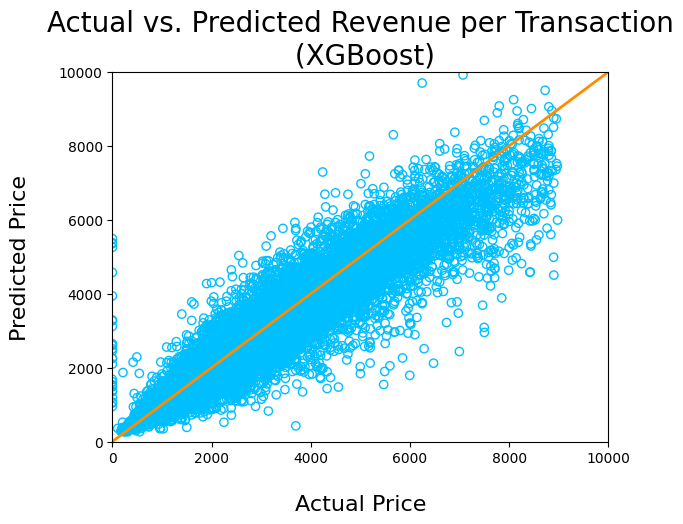

In [63]:
# Plot Actual vs. Predicted Revenue per Transaction
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n (XGBoost)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

#### b. Decision Tree Regressor

In [64]:
tuned_parameters_dt = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# GridSearch for Decision Tree
dtr_cv = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=tuned_parameters_dt,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearch on train set
dtr_cv.fit(X_train, y_train)

# Print best params and best R²
print(f"Best hyperparameters (Decision Tree): {dtr_cv.best_params_}\n")
print(f"Best R²: {dtr_cv.best_score_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters (Decision Tree): {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

Best R²: 0.7772130675625357


In [65]:
# Decision Tree Regressor with best hyperparameters
dtr_mod = DecisionTreeRegressor(
    random_state=42,
    max_depth=dtr_cv.best_params_["max_depth"],
    min_samples_split=dtr_cv.best_params_["min_samples_split"],
    min_samples_leaf=dtr_cv.best_params_["min_samples_leaf"]
)

# Fit the model
dtr_mod.fit(X_train, y_train)

# Predict on test set
y_pred_dtr = dtr_mod.predict(X_test)

# Print R² and RMSE
print(f"- {dtr_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_dtr)}")
print(f"RMSE: {rmse_score(y_test, y_pred_dtr)}")

- DecisionTreeRegressor
R²: 0.7859422925720454
RMSE: 0.2925219687573324


In [66]:
# Save results
model_list.append(dtr_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_dtr), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_dtr), 4))

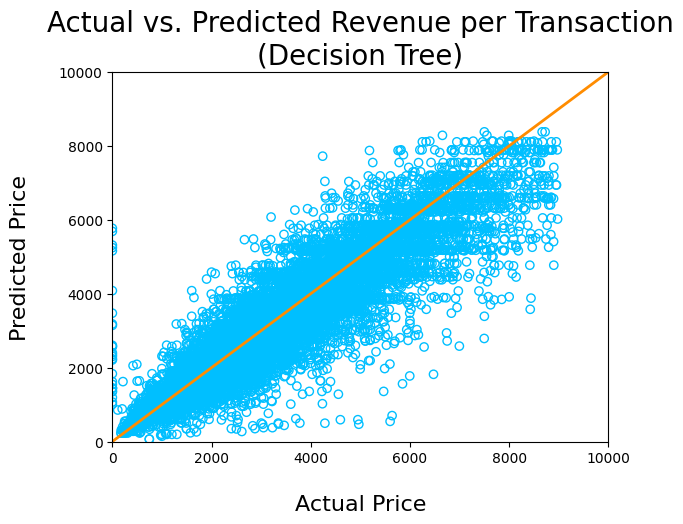

In [67]:
# Plot Actual vs. Predicted Revenue per Transaction
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_dtr)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(Decision Tree)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

#### c. Huber Regression

In [68]:
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for HuberRegressor
tuned_parameters_huber = {
    "epsilon": [1.1, 1.35, 1.5],  # controls sensitivity to outliers
    "alpha": [0.0001, 0.001, 0.01]  # regularization term
}

# GridSearch for HuberRegressor
huber_cv = GridSearchCV(
    estimator=HuberRegressor(),
    param_grid=tuned_parameters_huber,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='r2'
)

# Fit GridSearch on train set
huber_cv.fit(X_train, y_train)

# Print best params and best R²
print(f"Best hyperparameters (Huber): {huber_cv.best_params_}\n")
print(f"Best R²: {huber_cv.best_score_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best hyperparameters (Huber): {'alpha': 0.01, 'epsilon': 1.5}

Best R²: 0.7709502104682867


In [69]:
# Huber Regressor with best hyperparameters
huber_mod = HuberRegressor(
    epsilon=huber_cv.best_params_["epsilon"],
    alpha=huber_cv.best_params_["alpha"]
)

# Fit the model
huber_mod.fit(X_train, y_train)

# Predict on test set
y_pred_huber = huber_mod.predict(X_test)

# Print R² and RMSE
print(f"- {huber_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_huber)}")
print(f"RMSE: {rmse_score(y_test, y_pred_huber)}")

- HuberRegressor
R²: 0.77350674150013
RMSE: 0.30089896419729645


In [70]:
# Save results
model_list.append(huber_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_huber), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_huber), 4))

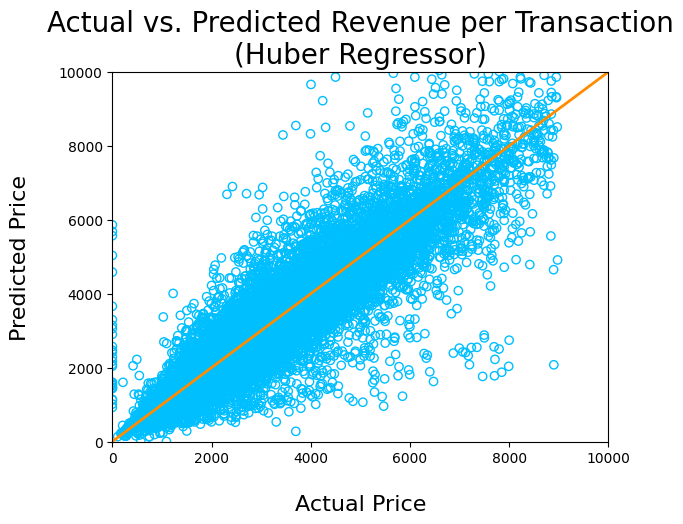

In [71]:
# Plot Actual vs. Predicted Revenue per Transaction
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_huber)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(Huber Regressor)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

#### d. Random Forest Regressor

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
param_dist_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10, None],
    "max_features": ["sqrt"],
    "min_samples_split": [2, 5],
}

# RandomizedSearch
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=5,            # hanya 5 kombinasi acak
    cv=3,                # 3-fold cross-validation untuk hemat waktu
    n_jobs=-1,
    verbose=1,
    scoring="r2",
    random_state=42
)

# Fit RandomizedSearch
rf_random.fit(X_train, y_train)

# Print
print(f"Best hyperparameters (Random Forest): {rf_random.best_params_}\n")
print(f"Best R²: {rf_random.best_score_}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyperparameters (Random Forest): {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': None}

Best R²: 0.7897191634446177


In [73]:
rf_mod = rf_random.best_estimator_

# Prediksi pada test set
y_pred_rf = rf_mod.predict(X_test)

# Evaluasi performa
print(f"- {rf_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_rf)}")
print(f"RMSE: {rmse_score(y_test, y_pred_rf)}")

- RandomForestRegressor
R²: 0.8001553650474458
RMSE: 0.28264369345118723


In [74]:
model_list.append(rf_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_rf), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_rf), 4))

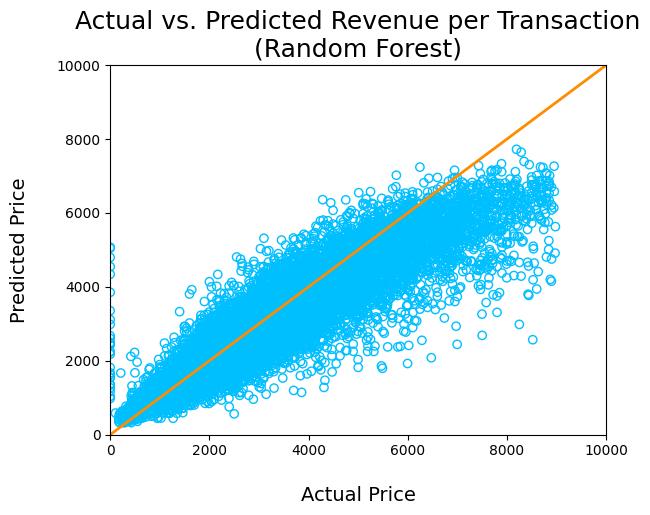

In [75]:
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_rf)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(Random Forest)", fontsize=18)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=14)
plt.ylabel("Predicted Price\n", fontsize=14)
plt.show()

#### e. LightGBM Regressor

In [76]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Define hyperparameters for LightGBM
tuned_parameters_lgb = {
    "num_leaves": [31, 50, 100],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500]
}

# GridSearchCV
lgb_cv = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=tuned_parameters_lgb,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="r2"
)

# Fit GridSearch
lgb_cv.fit(X_train, y_train)

# Print best params dan best R²
print(f"Best hyperparameters (LightGBM): {lgb_cv.best_params_}\n")
print(f"Best R²: {lgb_cv.best_score_}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1580
[LightGBM] [Info] Number of data points in the train set: 134328, number of used features: 80
[LightGBM] [Info] Start training from score 7.651698
Best hyperparameters (LightGBM): {'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 500, 'num_leaves': 50}

Best R²: 0.8041991662731849


In [77]:
lgb_mod = LGBMRegressor(
    random_state=42,
    num_leaves=lgb_cv.best_params_["num_leaves"],
    max_depth=lgb_cv.best_params_["max_depth"],
    learning_rate=lgb_cv.best_params_["learning_rate"],
    n_estimators=lgb_cv.best_params_["n_estimators"]
)

# Fit model
lgb_mod.fit(X_train, y_train)

# Predict pada test set
y_pred_lgb = lgb_mod.predict(X_test)

# Print R² dan RMSE
print(f"- {lgb_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_lgb)}")
print(f"RMSE: {rmse_score(y_test, y_pred_lgb)}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1580
[LightGBM] [Info] Number of data points in the train set: 134328, number of used features: 80
[LightGBM] [Info] Start training from score 7.651698
- LGBMRegressor
R²: 0.8117351415480507
RMSE: 0.27433276694355935


In [78]:
model_list.append(lgb_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_lgb), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_lgb), 4))

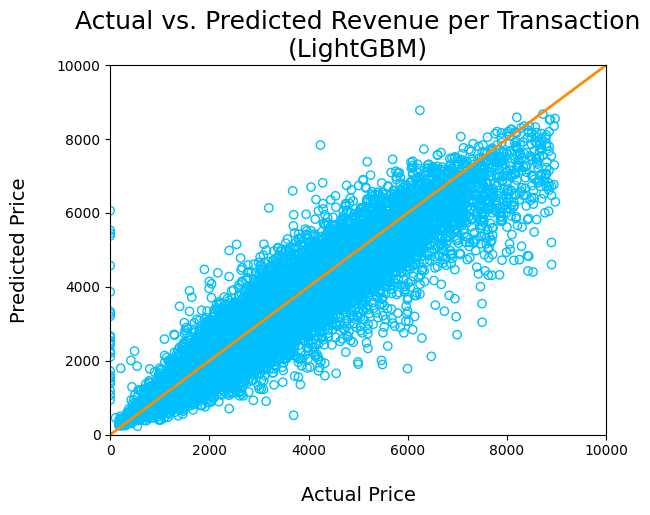

In [79]:
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_lgb)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(LightGBM)", fontsize=18)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=14)
plt.ylabel("Predicted Price\n", fontsize=14)
plt.show()

#### f. CatBoost Regressor

In [80]:
from catboost import CatBoostRegressor

# Define hyperparameters for CatBoost
tuned_parameters_catboost = {
    "depth": [4, 6, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "iterations": [100, 500]
}

# GridSearchCV for CatBoost
catboost_cv = GridSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),
    param_grid=tuned_parameters_catboost,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="r2"
)

# Fit GridSearch
catboost_cv.fit(X_train, y_train)

# Print best parameters and best R²
print(f"Best hyperparameters (CatBoost): {catboost_cv.best_params_}\n")
print(f"Best R²: {catboost_cv.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best hyperparameters (CatBoost): {'depth': 10, 'iterations': 500, 'learning_rate': 0.05}

Best R²: 0.803689338074264


In [81]:
# CatBoost Regressor with best hyperparameters
catboost_mod = CatBoostRegressor(
    depth=catboost_cv.best_params_["depth"],
    learning_rate=catboost_cv.best_params_["learning_rate"],
    iterations=catboost_cv.best_params_["iterations"],
    verbose=0
)

# Fit model
catboost_mod.fit(X_train, y_train)

# Predict pada test set
y_pred_catboost = catboost_mod.predict(X_test)

# Print R² dan RMSE
print(f"- {catboost_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_catboost)}")
print(f"RMSE: {rmse_score(y_test, y_pred_catboost)}")

- CatBoostRegressor
R²: 0.8111621349877948
RMSE: 0.2747499320164419


In [82]:
model_list.append(catboost_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_catboost), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_catboost), 4))

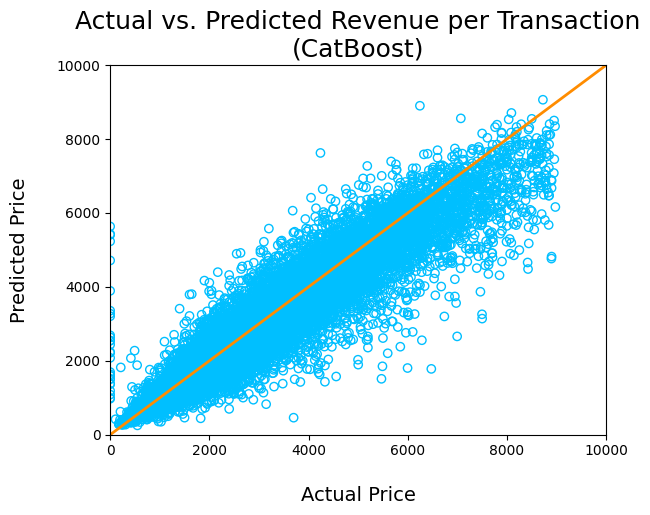

In [83]:
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_catboost)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(CatBoost)", fontsize=18)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=14)
plt.ylabel("Predicted Price\n", fontsize=14)
plt.show()

In [84]:
# Create a table with pd.DataFrame
model_results = pd.DataFrame(
    {
        "Model": model_list,
        "R²": r2_list,
        "RMSE": rmse_list
    }
)

model_results = model_results.sort_values(by="R²", ascending=False).reset_index(drop=True)
model_results

,Model,R²,RMSE
0,LGBMRegressor,0.8117,0.2743
1,CatBoostRegressor,0.8112,0.2747
2,XGBRegressor,0.8092,0.2762
3,RandomForestRegressor,0.8002,0.2826
4,DecisionTreeRegressor,0.7859,0.2925
5,HuberRegressor,0.7735,0.3009


# Deployment

In [85]:
# ==== Save artifacts for Streamlit inference ====
# Why: LGBM model was trained WITH preprocessing (log1p on skewed cols,
# RobustScaler, and a specific feature subset/order). If only save the model,
# predictions in Streamlit will be wrong or crash. We therefore save:
# 1) the trained scaler, 2) the trained model, 3) the exact feature order used,
# 4) which columns were log-transformed during training.

import json
import joblib

# Safety checks to avoid exporting half-baked objects
assert "scaler" in globals(), "scaler not found. Fit RobustScaler before exporting."
assert "lgb_mod" in globals(), "lgb_mod not found. Train your LGBM model first."
assert "X_train" in globals(), "X_train not found. Make sure your final feature set exists."
assert "sk_features" in globals(), "sk_features not found. Compute skewed columns first."

# 1) Save the RobustScaler fitted on TRAIN data
joblib.dump(scaler, "scaler.pkl")

# 2) Save the trained LightGBM model (predicts on *log* target: subtotal_log)
joblib.dump(lgb_mod, "lgbm_model.pkl")

# 3) Save the exact feature order used at training time
#    (after backward stepwise + VIF drops). Inference MUST respect this order.
feature_order = list(X_train.columns)
with open("feature_order.json", "w") as f:
    json.dump(feature_order, f)

# 4) Save which numeric columns were log-transformed (so we can replicate inference)
with open("skewed_cols.json", "w") as f:
    json.dump(list(sk_features), f)

print("Artifacts saved: scaler.pkl, lgbm_model.pkl, feature_order.json, skewed_cols.json")


Artifacts saved: scaler.pkl, lgbm_model.pkl, feature_order.json, skewed_cols.json
